In [1]:
import sys
sys.path.append("/home/ex/Documents/Hons/CBT/Skogestad-Python")
import utils
import numpy
import matplotlib.pyplot as plt
import scipy.linalg
import cvxpy

In [2]:
class StepModel:
    def __init__(self, G, dt, N, P, M, integrators=True):
        self.G = G
        self.dt = dt
        self.N = N
        self.P = P
        self.M = M
        self.integrators = integrators
        
        self.outs, self.ins = self.G.D11.shape
        
        self.__make_step_coeffs()
        self.__make_step_matrix()
        
        self.Y0 = numpy.zeros(self.A.shape[0])        
    
    def step_Y0(self, dU): # Untested. Will test with MPC implementation        
        Im = numpy.eye(self.outs)
        M_siso = numpy.eye(self.P, k=1)
        M_siso[self.P-1][self.P-1] = 1
        M = numpy.kron(M_siso, Im)
        
        A_star = self.A[:, ::self.M]
        
        self.Y0 += M @ self.Y0 + A_star @ dU
        
    def reset(self):
        self.Y0 = numpy.zeros(self.A.shape[0])  
        
    def __make_step_coeffs(self):        
        t= self.N*self.dt
        ts = numpy.linspace(0 , t, int(t*100))
        tstep = numpy.arange(0, t, self.dt)
        ind = numpy.searchsorted(ts, tstep)
        ysteps = numpy.zeros_like(self.G.D11).tolist()

        for in_i in range(self.ins): 
            uf = lambda t: [0]*in_i + [1] + [0]*(self.ins-in_i-1)
            ys = self.G.simulate(uf, ts)

            for out_i in range(self.outs):
                yi = ys[:, out_i][ind]
                largest = 1e4
                yi[yi>largest] = largest
                yi[yi<-largest] = -largest
                ysteps[out_i][in_i] = yi
                
        self.ysteps = numpy.array(ysteps)
        
    def __make_step_matrix(self):
        if self.P < self.N:
            cols = self.ysteps[:, :, :self.P] 
        else:
            a = numpy.moveaxis(numpy.tile(self.ysteps[:, :, -1], (self.P - self.N,1,1)), 0, -1)
            cols = numpy.append(self.ysteps, a, axis=2)
        
        rows = numpy.append(self.ysteps[:, :, :1], numpy.zeros((self.outs, self.ins, self.M-1)), axis=2)
        As = numpy.zeros_like(self.G.D11).tolist()

        for in_i in range(self.ins): 
            for out_i in range(self.outs):
                As[out_i][in_i] = scipy.linalg.toeplitz(cols[out_i][in_i], rows[out_i][in_i])

        self.A = numpy.block(As)
        
        if self.integrators:
            self.__make_integrators_matrix()
            self.A += self.B
        
        
    def __make_integrators_matrix(self):
        dys = self.ysteps[:, :, -1] - self.ysteps[:, :, -2]

        if P < N:
            cols = numpy.zeros((self.outs, self.ins, self.P))
        else:
            a = numpy.tile(numpy.arange(1, self.P-self.N+1), (2, 2, 1))
            cols = numpy.append(numpy.zeros((self.outs, self.ins, self.N)), a, axis=2)
        rows = numpy.zeros((self.outs, self.ins, self.M))

        Bs = numpy.zeros_like(self.G.D11).tolist()

        for in_i in range(self.ins): 
            for out_i in range(self.outs):
                Bs[out_i][in_i] = scipy.linalg.toeplitz(cols[out_i][in_i], rows[out_i][in_i]) * dys[out_i][in_i]

        self.B = numpy.block(Bs)

In [3]:
# Slightly adapted from  H/W assignment 9
num = [[[-0.045], [-0.048]], [[-0.23], [0.55]]]
den = [[[1, -4, 5], [11, 1]], [[8.1, 1], [10, 1]]] # [[[8.1, 1], [11, 1]], [[8.1, 1], [10, 1]]]
delay = [[0.5, 0.5], [1.5, 0.5]]
G = utils.InternalDelay.from_tf_coefficients(num, den, delay)

In [4]:
N = 50
dt = 0.5
M = 20
P = M+N

SM = StepModel(G, dt, N, P, M)

In [5]:
class ModelPredictiveController:
    def __init__(self, SM, Q=None, R=None, dU_max=None, E_max=None):
        self.SM = SM
        self.dU = cvxpy.Variable(SM.M*SM.ins)
        self.Y = SM.A @ self.dU
        self.Ysp = numpy.full(SM.P*SM.outs, 0)
        self.E = self.Ysp - self.Y
        
        SM.reset()
        
        if Q is None:
            Q = numpy.ones(SM.P*SM.outs)
        
        self.Q = numpy.diag(Q)
        
        if R is None:
            R = numpy.ones(SM.M*SM.ins)
        
        self.R = numpy.diag(R)
        
        if dU_max is None:
            dU_max = 1e20
        
        self.dU_max = dU_max
        
        if E_max is None:
            E_max = 1e20
        
        self.E_max = E_max
        
        self.J = cvxpy.quad_form(self.E, self.Q) + cvxpy.quad_form(self.dU, self.R)
        self.obj = cvxpy.Minimize(self.J)
        self.cons = [cvxpy.abs(self.dU) <= self.dU_max, cvxpy.abs(self.E) <= self.E_max]
        prob = cvxpy.Problem(self.obj, self.cons)
        prob.solve(solver='MOSEK')
        
    def step(self, Yactual, Ysp=None):
        
        if Ysp is not None:
            self.Ysp = Ysp
        
        self.bias = numpy.repeat(Yactual - self.Y.value[::SM.P], SM.P) 

        self.Y = SM.A @ self.dU + SM.Y0 + self.bias
        self.E = self.Ysp - self.Y
        self.J = cvxpy.quad_form(self.E, self.Q) + cvxpy.quad_form(self.dU, self.R)
        self.obj = cvxpy.Minimize(self.J)
        self.cons = [cvxpy.abs(self.dU) <= self.dU_max, cvxpy.abs(self.E) <= self.E_max]
        
        self.prob = cvxpy.Problem(self.obj, self.cons)
        self.prob.solve(solver='MOSEK', warm_start=True)
        
        if self.prob.solution.status != 'optimal':
            print("Solving problem without constraints")
            self.prob = cvxpy.Problem(self.obj)
            self.prob.solve(solver='MOSEK', warm_start=True)
            if self.prob.solution.status == 'optimal':
                print("It worked!")
        
        dU_out = self.dU.value[::SM.M]
        SM.step_Y0(dU_out)
        
        return dU_out

In [6]:
# MPC.prob.solve(solver='MOSEK', warm_start=True, verbose=True)

In [7]:
MPC = ModelPredictiveController(SM, dU_max=10, E_max=15)
Ysp = numpy.full(P*SM.outs, 10)
MPC.step([0, 0], Ysp)

array([3.40537392e-04, 8.37582775e+00])

In [8]:
dUs = cvxpy.Variable(M*SM.ins)
R = numpy.full(P*SM.outs, 0)
Y = SM.A @ dUs
E = R - Y

obj = cvxpy.Minimize(cvxpy.quad_form(E, numpy.eye(P*SM.outs)))
cons = [cvxpy.abs(dUs) <= 10, cvxpy.abs(E) <= 15]

R = numpy.full(P*SM.outs, 10)
E = R - Y
obj = cvxpy.Minimize(cvxpy.quad_form(E, numpy.eye(P*SM.outs)))

prob = cvxpy.Problem(obj, cons)
prob.is_dcp()

True

In [9]:
prob.is_qp()

True

In [10]:
# ECOS, ECOS_BB, OSQP, and SCS
prob.solve(solver='MOSEK', warm_start=True)

6881.955015612922

In [11]:
dUs.value[::M]

array([3.40647907e-04, 9.99999979e+00])

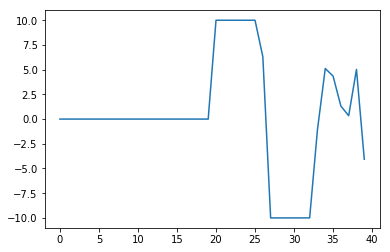

In [12]:
plt.plot(dUs.value)
plt.show()

In [13]:
Y.value.shape

(140,)

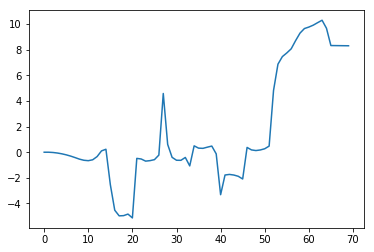

In [14]:
plt.plot(Y.value[:70])
plt.show()

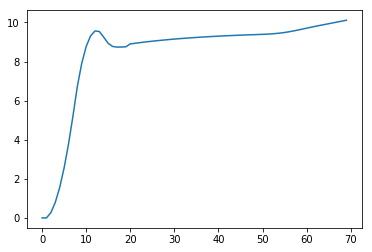

In [15]:
plt.plot(Y.value[70:])
plt.show()

In [17]:
a = SM.A

In [20]:
numpy.linalg.inv(a.T @ a) @ a.T

array([[ 0.00000000e+00,  0.00000000e+00, -5.89975614e-10, ...,
         5.60763684e-08,  5.63368334e-08,  5.65972983e-08],
       [ 0.00000000e+00,  0.00000000e+00, -1.25313282e-10, ...,
         1.97426193e-08,  1.98412449e-08,  1.99398705e-08],
       [ 0.00000000e+00,  0.00000000e+00,  2.70563894e-13, ...,
         1.21534892e-08,  1.22218235e-08,  1.22901578e-08],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  3.27733164e-06, ...,
         3.70392791e-05,  3.68492492e-05,  3.66592195e-05],
       [ 0.00000000e+00,  0.00000000e+00, -6.35833580e-03, ...,
        -1.35504656e+00, -1.36361290e+00, -1.37217923e+00],
       [ 0.00000000e+00,  0.00000000e+00,  6.98168048e-03, ...,
         1.43483776e+00,  1.44390253e+00,  1.45296731e+00]])